In [48]:
import numpy as np
import matplotlib.pyplot as plt

In [49]:
# Cylinder dimensions
cyl_length = 3000 # mm
cyl_r = 100 # mm
arc_res = 6 # Number of elements in 90 deg arc
thick_max = 5.5
thick_min = 5.0

# Rotatinal bc
time_end = 10.0       # End time
rot_vel_init = 15.0   # Initial rotational speed, rad/s
rot_vel_end = 100.0   # Rotational speed at end, rad/s 

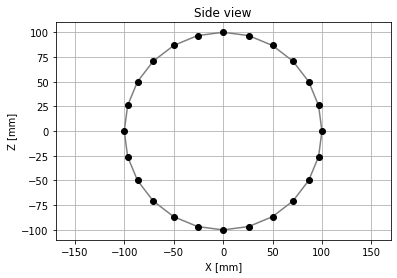

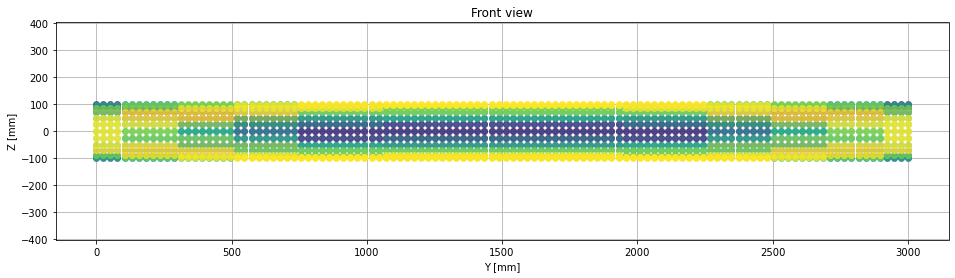

In [50]:
# Radial node locations
theta = np.linspace(0, 2*np.pi, num=arc_res*4, endpoint=False)
base_x = cyl_r*np.sin(theta)
base_z = cyl_r*np.cos(theta)

# Axial node locations
elem_length = np.sqrt((base_x[0]-base_x[1])**2+(base_z[0]-base_z[1])**2)
base_y = np.linspace(0,cyl_length,int(np.round(cyl_length/elem_length))+1)

plt.plot(base_x,base_z,'grey')
plt.plot([base_x[0],base_x[-1]],[base_z[0],base_z[-1]],'grey')
plt.plot(base_x,base_z,'ko')
plt.axis('equal')
plt.grid()
plt.title('Side view')
plt.xlabel('X [mm]')
plt.ylabel('Z [mm]')
plt.show()

# Thickness variation
thickness = np.linspace(thick_min, thick_max, arc_res)

y_change = np.round(np.sin(np.linspace(0,1*np.pi,base_y.shape[0]))*(arc_res-1))
circ_change = np.round(np.abs(np.sin(np.linspace(0,2*np.pi,base_x.shape[0])))*(arc_res-1)+1)

# Creating nodes for cylinder surface
idx = 0
color_idx = np.zeros(base_y.shape[0]*base_x.shape[0])
for k in range(base_y.shape[0]):
    #temp = circ_change[int(y_change[k])+i % len(circ_change)]
    for i in range(base_x.shape[0]):
        m = (int(y_change[k]) + 1) % len(base_x)
        n = (i + m) % len(base_x)
        #print(m,n)
        #print(circ_change[(int(y_change[k])+i) % len(circ_change)])
        color_idx[idx] = int(circ_change[n])
        
        idx += 1

node_x = np.zeros(base_x.shape[0]*base_y.shape[0])
node_y = np.zeros(node_x.shape)
node_z = np.zeros(node_x.shape)

# Creating nodes for cylinder surface
idx = 0


for k in base_y:
    for i in range(base_x.shape[0]):
        node_x[idx] = base_x[i]
        node_z[idx] = base_z[i]
        node_y[idx] = k
        idx += 1

plt.figure(figsize=(16,4))

colors = plt.cm.viridis(np.linspace(0,1,arc_res))
for i in range(arc_res):
    mask = color_idx==(i+1)
    plt.plot(node_y[mask],node_z[mask],'o',color=colors[i], alpha=0.7)
plt.axis('equal')
plt.grid()
plt.title('Front view')
plt.xlabel('Y [mm]')
plt.ylabel('Z [mm]')
plt.show()        

n_cyl = node_x.shape[0]

# Adding RBE center nodes
node_x = np.hstack((node_x,0.0))
node_y = np.hstack((node_y,0.0))
node_z = np.hstack((node_z,0.0))
id_end0 = len(node_x)

node_x = np.hstack((node_x,0.0))
node_y = np.hstack((node_y,cyl_length))
node_z = np.hstack((node_z,0.0))
id_end1 = len(node_x)

# Adding ground nodes
node_x = np.hstack((node_x,0.0))
node_y = np.hstack((node_y,0.0))
node_z = np.hstack((node_z,-cyl_r))
id_ground0 = len(node_x)

node_x = np.hstack((node_x,0.0))
node_y = np.hstack((node_y,cyl_length))
node_z = np.hstack((node_z,-cyl_r))
id_ground1 = len(node_x)

In [51]:
n_shell_elem = arc_res*4*(base_y.shape[0]-1)
elem_idx = np.zeros((n_shell_elem,6),dtype=int)

# Starting element index, could be any integer
idx_ele = 10000

# Nodes to shell elements
idx = 0
offset = 0
for i in range(base_y.shape[0]-1):
    for j in range(base_x.shape[0]-1):
        elem_idx[idx,0] = idx+idx_ele
        elem_idx[idx,1] = j+1+offset
        elem_idx[idx,2] = j+2+offset
        elem_idx[idx,3] = j+2+(i+1)*base_x.shape[0]
        elem_idx[idx,4] = j+1+(i+1)*base_x.shape[0]
        elem_idx[idx,5] = int(np.ceil(np.sum(color_idx[elem_idx[idx,1:5]-1])/4))
        idx += 1
    j += 1
    # Creating the last element, last nodes to first nodes
    elem_idx[idx,0] = idx+idx_ele
    elem_idx[idx,1] = j+1+offset
    elem_idx[idx,2] = 1 + offset
    elem_idx[idx,3] = 1 +(i+1)*base_x.shape[0]
    elem_idx[idx,4] = j+1+(i+1)*base_x.shape[0]
    elem_idx[idx,5] = int(np.ceil(np.sum(color_idx[elem_idx[idx,1:5]-1])/4))
    idx += 1
        
    offset += base_x.shape[0]

In [62]:
# Creating a basic simulation file for RADIOSS
lines = []

# Starter lines
lines.append('#RADIOSS STARTER')
lines.append('##========================================================================================')
lines.append('## Generated with Python')
lines.append('##========================================================================================')
lines.append('/BEGIN')              
lines.append('example_file')                        
lines.append('#   Invers      Irun')
lines.append('      2021         0')
lines.append('#    Input_mass_unit   Input_length_unit     Input_time_unit')
lines.append('                  Mg                  mm                   s')
lines.append('#     Work_mass_unit    Work_length_unit      Work_time_unit')
lines.append('                  Mg                  mm                   s')
lines.append('##')
lines.append('##')

# Basic material definition
lines.append('##---------------------------------------------')
lines.append('## Material')
lines.append('##---------------------------------------------')
lines.append('/MAT/ELAST/3')
lines.append('Steel')
lines.append('#                 Pi')
lines.append('            7.85E-09')
lines.append('#                  E                   v               Emaxp                  Et                  Em')
lines.append('        10000.000000            0.290000')
                                                                                

# Adding nodes
n_node = 1
lines.append('/NODE')
for i in range(node_x.shape[0]):
    l1 = len(str(n_node))
    x_str = str(np.round(node_x[i],6))
    l2 = len(x_str)
    y_str = str(np.round(node_y[i],6))
    l3 = len(y_str)
    z_str = str(np.round(node_z[i],6))
    l4 = len(z_str)
    # This creates the node input lines with specific whitespaces
    lines.append((10-l1)*' '+str(n_node)+' '*(20-l2)+x_str+' '*(20-l3)+y_str+' '*(20-l4)+z_str)
    n_node += 1

lines.append('##---------------------------------------------')
lines.append('## Spring Elements')
lines.append('##---------------------------------------------')
lines.append('/SPRING/58')
lines.append('#  sprg_ID  node_ID1  node_ID2                                                               skew_ID')
lines.append('   1000002'+(10-len(str(id_end0)))*' '+str(id_end0) + (10-len(str(id_ground0)))*' '+str(id_ground0))
lines.append('   1000003'+(10-len(str(id_end1)))*' '+str(id_end1) + (10-len(str(id_ground1)))*' '+str(id_ground1))

    
# Adding elements 
lines.append('##---------------------------------------------')
lines.append('## Quad Shell Elements')
lines.append('##---------------------------------------------')
for j in range(arc_res):
    lines.append('/SHELL/'+str(10+j))
    for i in range(elem_idx.shape[0]):
        if elem_idx[i,5] == (j+1):
            l0 = len(str(elem_idx[i,0]))
            n1_str = str(elem_idx[i,1])
            l1 = len(n1_str)
            n2_str = str(elem_idx[i,2])
            l2 = len(n2_str)
            n3_str = str(elem_idx[i,3])
            l3 = len(n3_str)
            n4_str = str(elem_idx[i,4])
            l4 = len(n4_str)
            lines.append((10-l0)*' '+str(elem_idx[i,0]) +' '*(10-l1)+n1_str +' '*(10-l2)+n2_str +' '*(10-l3)+n3_str +' '*(10-l4)+n4_str)

# Adding RBE to cylinder ends
lines.append('/GRNOD/NODE/1')
lines.append('RBE01')
idx = 0
line = ''
for i in range(base_x.shape[0]):
    line += (10-len(str(i+1)))*' '+str(i+1)
    idx += 1
    if idx == 10:
        lines.append(line)
        line = ''
        idx = 0
lines.append(line)
lines.append('/RBE2/1')
lines.append('RBE01')
l0 = len(str(id_end0)) 
lines.append((10-l0)*' '+str(id_end0)+'   111 111                   1         0')

lines.append('/GRNOD/NODE/2')
lines.append('RBE02')
idx = 0
line = ''
for i in range(base_x.shape[0]):
    line += (10-len(str(n_cyl-i)))*' '+str(n_cyl-i)
    idx += 1
    if idx == 10:
        lines.append(line)
        line = ''
        idx = 0
lines.append(line)
lines.append('/RBE2/1')
lines.append('RBE02')
l0 = len(str(id_end1)) 
lines.append((10-l0)*' '+str(id_end1)+'   111 111                   2         0')

# Gravity
lines.append('##---------------------------------------------')
lines.append('/GRAV/1')
lines.append('Global Condition    ')                                                                                
lines.append('#funct_IDT       DIR   skew_ID sensor_ID  grnod_ID                      Ascale_x            Fscale_Y')
lines.append('         0         Z         0         0         0                                           -9820.0')
lines.append('##---------------------------------------------')

# Constraints
lines.append('##---------------------------------------------')
lines.append('/GRNOD/NODE/3')
lines.append('Node_Constraint_A')
l0 = len(str(id_end0))
lines.append((10-l0)*' '+str(id_end0))
lines.append('/BCS/1')
lines.append('Node_Constraint_A')
lines.append('#   Trarot   Skew_ID   grnd_ID')
lines.append('   110 101                   3')
lines.append('##---------------------------------------------')
lines.append('/GRNOD/NODE/4')
lines.append('Node_Constraint_B')
l0 = len(str(id_end1))
lines.append((10-l0)*' '+str(id_end1))
lines.append('/BCS/2')
lines.append('Node_Constraint_B')
lines.append('#   Trarot   Skew_ID   grnd_ID')
lines.append('   110 101                   4')
lines.append('##---------------------------------------------')

lines.append('##---------------------------------------------')
lines.append('/GRNOD/NODE/7')
lines.append('Node_Constraint_C')
l0 = len(str(id_ground0))
lines.append((10-l0)*' '+str(id_ground0))
lines.append('/BCS/3')
lines.append('Node_Constraint_C')
lines.append('#   Trarot   Skew_ID   grnd_ID')
lines.append('   111 000                   7')
lines.append('##---------------------------------------------')
lines.append('/GRNOD/NODE/8')
lines.append('Node_Constraint_D')
l0 = len(str(id_ground1))
lines.append((10-l0)*' '+str(id_ground1))
lines.append('/BCS/4')
lines.append('Node_Constraint_D')
lines.append('#   Trarot   Skew_ID   grnd_ID')
lines.append('   111 000                   8')
lines.append('##---------------------------------------------')

# Velocity table
lines.append('##---------------------------------------------')
lines.append('/FUNCT/2')
lines.append('VelocityTable')
#                         Time               Rot. vel.
temp = (20-len(str(np.round(rot_vel_init,6))))*' '+str(np.round(rot_vel_init,6))
lines.append('            0.000000'+temp)
temp1 = (20-len(str(np.round(time_end,6))))*' '+str(np.round(time_end,6))
temp2 = (20-len(str(np.round(rot_vel_end,6))))*' '+str(np.round(rot_vel_end,6))
lines.append(temp1+temp2)
lines.append('##---------------------------------------------')

# Velocity
lines.append('##---------------------------------------------')
lines.append('/GRNOD/NODE/5')
lines.append('VelocityConstraintRY')
lines.append((10-l0)*' '+str(id_end1))
lines.append('/IMPVEL/1')
lines.append('VelocityConstraint_12_YY')
lines.append('#  fct_IDT       Dir   Skew_ID   sens_ID   grnd_ID  frame_ID     icoor')
lines.append('         2        YY                             5                    ')
lines.append('#            Ascalex             FscaleY              Tstart               Tstop')
temp = (20-len(str(np.round(time_end,6))))*' '+str(np.round(time_end,6))
lines.append('            1.000000            1.000000            0.000000'+temp)
lines.append('##---------------------------------------------')

# Shell property
for j in range(arc_res):
    temp = (10-len(str(np.round(thickness[j],3))))*' '+str(np.round(thickness[j],3))
    lines.append('##---------------------------------------------')
    lines.append('/PROP/SHELL/'+str(j+1))
    lines.append('Property'+str(j+1))
    lines.append('#   Ishell    Ismstr     Ish3n     Idril                             P_thickfail')
    lines.append('        12         4         0         0')
    lines.append('#                 hm                  hf                  hr                  dm                  dn')
    lines.append('            0.010000            0.010000            0.010000            0.000000            0.000000')
    lines.append('#        N   Istrain               Thick              Ashear              Ithick     Iplas')
    lines.append('         5         0          '+temp+'            0.000000                   0         0')

# Spring definition
lines.append('##---------------------------------------------')
lines.append('/PROP/SPRING/20')
lines.append('property_spring          ')                                                                           
lines.append('#               MASS                                 sens_ID    Isflag     Ileng')
lines.append('                0.01')                                                                              
lines.append('#                 K1                  C1                  A1                  B1                  D1')
lines.append('               100.0               50.05')
lines.append('# fct_ID11        H1  fct_ID21  fct_ID31  fct_ID41                      DeltaMin            DeltaMax')
lines.append('')                                                                                                    
lines.append('#                 F1                  E1             AScale1             Hscale1')
lines.append('##---------------------------------------------')

#Output on specific nodes
lines.append('##---------------------------------------------')
lines.append('/TH/NODE/1')
lines.append('output_nodes')                                                                                        
lines.append('XYZ')       
val = int(base_y.shape[0]/2*base_x.shape[0]) + arc_res
temp = (10-len(str(val)))*' '+str(val)
lines.append(temp+'         0') 
val = int(base_y.shape[0]/2*base_x.shape[0]) + 3*arc_res
temp = (10-len(str(val)))*' '+str(val)
lines.append(temp+'         0')                 
lines.append('##---------------------------------------------')

#Initial rotational velocity
lines.append('##---------------------------------------------')
lines.append('/INIVEL/AXIS/1')
lines.append('InitVelocity_11')
lines.append('#      Dir  frame_ID   grnd_ID')
lines.append('         Y                   6')
lines.append('#                 VX                  VY                  VZ                  VR')
temp = (20-len(str(np.round(rot_vel_init,6))))*' '+str(np.round(rot_vel_init,6))
lines.append('            0.000000            0.000000            0.000000'+temp)
lines.append('##---------------------------------------------')

lines.append('/GRNOD/NODE/6')
lines.append('#title')                                                                                              
lines.append('InitVelocity_Y')                
idx = 0
line = ''
for i in range(n_cyl):
    line += (10-len(str(1+i)))*' '+str(1+i)
    idx += 1
    if idx == 10:
        lines.append(line)
        line = ''
        idx = 0
lines.append(line)             
             
# End lines    
lines.append('##---------------------------------------------')
lines.append('## Parts')
lines.append('##---------------------------------------------')
lines.append('##HWCOLOR components ')

for j in range(arc_res):
    lines.append('/PART/'+str(10+j))
    lines.append('Cylinder_own'+str(10+j))
    lines.append((10-len(str(1+j)))*' '+str(1+j)+'         3')

lines.append('/PART/58')
lines.append('SpringDamper_1')
lines.append('        20         0')

lines.append('/END ')   
    
with open("example_file_0000.rad", "w") as file:
    print('Writing ...0000.rad file...')
    for line in lines:
        file.write(line)
        file.write('\n')
        
#This writes the run definition file
lines2 = []
lines2.append('/RUN/example_file/1/')
lines2.append(str(np.round(time_end,6))) 
lines2.append('/STOP')
lines2.append('0.000000000000000    0.000000000000000    0.000000000000000    1          1          1     ')    
lines2.append('/PARITH/OFF')
lines2.append('/VERS/2021')
lines2.append('/TFILE/0         ')
lines2.append('0.001000000000000   ')
lines2.append('/H3D/DT')
lines2.append('0.000000000000000    0.005000000000000   ')
lines2.append('/H3D/NODA/ACC')
lines2.append('/H3D/NODA/DIS')
lines2.append('/H3D/NODA/VEL')
lines2.append('/H3D/NODA/GPS')
lines2.append('/H3D/SHELL/ENER')
lines2.append('/H3D/SHELL/THICK')
lines2.append('/H3D/SHELL/VONM')
lines2.append('/H3D/SOLID/TENS/STRESS')

with open("example_file_0001.rad", "w") as file:
    print('Writing ...0001.rad file...')
    for line in lines2:
        file.write(line)
        file.write('\n')
        
print('Done')

Writing ...0000.rad file...
Writing ...0001.rad file...
Done


1398